#### Import modules and packages and set some settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

In [2]:
sns.set(rc={'figure.figsize':(15, 10)})

#### Definition of some useful functions

In [3]:
def get_iqr(data: pd.DataFrame, feature: str) -> dict:
    """
    Function calculates Q1 (0.25-quantile), Q3 (0.75 quantile), IQR (Interquantile range)
    and returns lower and upper borders of boxplot for selected column (feature) in dataframe

    :param    data: data
    :type     data: pd.DataFrame
    :param feature: column to select
    :type  feature: str

    :raise ValueError: if feature is not in data.columns

    :return: dict with Q1, Q3, IQR, lower border, upper border of boxplot
    """

    result = {}

    if feature in data.columns:

        q1, q3 = np.quantile(data[feature], [0.25, 0.75])
        iqr = q3 - q1
        x_1, x_2 = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        if data[feature].min() > 0 and x_1 < 0:
            x_1 = 0

        result = {'Q1': q1, 'Q3': q3, 'IQR': iqr, 'Q1_IQR': x_1, 'Q2_IQR': x_2}
    else:
        raise ValueError(f"Column {feature} not in df columns")

    return result

def del_ouliers(data: pd.DataFrame, feature: str, up_bord: float, down_bord: float) -> pd.DataFrame:
    """

    Function selects rows of dataframe with condition by column

    :param      data: data
    :type       data: pd.DataFrame
    :param   feature: conditional column
    :type    feature: str
    :param   up_bord: upper border of feature
    :type    up_bord: float
    :param down_bord: lower border of feature
    :type  down_bord: float

    :raise ValueError: if data (pd.DataFrame) is empty 
    :raise ValueError: if dataframe doesnt contain column with name `feature`

    :return: slice from dataframe

    """
    if data.empty:
        raise ValueError('Dataframe is empty. Check data.')
    
    if feature not in data.columns:
        raise ValueError(f'Dataframe doesn\'t contain column with name {feature}')

    tmp = data.copy()
    
    return tmp[(tmp[feature] > down_bord) & (tmp[feature] < up_bord)]



#### Import train and prediction datasets (data with target, data to predict)

In [4]:
data = pd.concat([pd.read_csv('./data/linreg_train.csv', index_col=0), pd.read_csv('./data/linreg_y_train.csv', index_col=0)], axis=1)
to_predict = pd.read_csv('./data/linreg_test.csv', index_col=0)

#### Making EDA!

Get info about columns: name, type of data, number of unique values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64556 entries, 5912 to 1606
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         64556 non-null  object 
 1   year          64556 non-null  int64  
 2   transmission  64556 non-null  object 
 3   mileage       64556 non-null  int64  
 4   fuelType      64556 non-null  object 
 5   tax           64556 non-null  int64  
 6   mpg           64556 non-null  float64
 7   engineSize    64556 non-null  float64
 8   car_maker     64556 non-null  object 
 9   price         64556 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


There aren't any missed values: 64556 non-null values for each column

In [6]:
data.describe()

,year,mileage,tax,mpg,engineSize,price
count,64556.000000,64556.000000,64556.000000,64556.000000,64556.000000,64556.000000
mean,2017.114102,23031.711491,118.783072,55.846761,1.716775,18136.018062
std,2.132108,21499.436955,64.560914,17.039259,0.590944,10266.777814
min,1996.000000,1.000000,0.000000,1.100000,0.000000,650.000000
25%,2016.000000,6970.750000,125.000000,47.900000,1.200000,10991.000000
50%,2017.000000,17162.500000,145.000000,55.400000,1.600000,15998.000000
75%,2019.000000,32387.500000,145.000000,64.200000,2.000000,22490.000000
max,2060.000000,323000.000000,580.000000,470.800000,6.600000,154998.000000


There is outlier in column `year`: value 2060

In [7]:
for col in data.columns[:-1]:
    print(f"name: {col} | type: {data[col].dtype} | nunique: {data[col].nunique()}")

name: model | type: object | nunique: 155
name: year | type: int64 | nunique: 26
name: transmission | type: object | nunique: 4
name: mileage | type: int64 | nunique: 33293
name: fuelType | type: object | nunique: 5
name: tax | type: int64 | nunique: 47
name: mpg | type: float64 | nunique: 186
name: engineSize | type: float64 | nunique: 40
name: car_maker | type: object | nunique: 7


### Working with target column

<AxesSubplot:xlabel='price', ylabel='Count'>

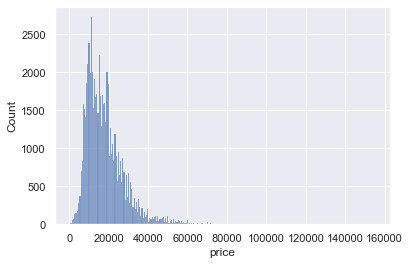

In [8]:
sns.histplot(data['price'])

The distribution of target column `price` is left-sided. If we apply log function, it will increase prediction's quality (later it will be done by TargetResgressor Trasnform)

<AxesSubplot:xlabel='price', ylabel='Count'>

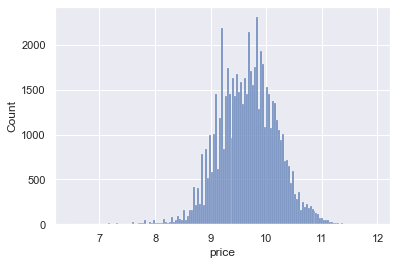

In [9]:
sns.histplot(np.log(data['price']))

#### Working with all columns

In [10]:
numerical = data.drop(columns=['price']).select_dtypes(include=['int64', 'float64']).columns.values
categor_cal = data.select_dtypes(include=['object']).columns.values

Making heatmap with correlation (Spearman for numerical data)

<AxesSubplot:>

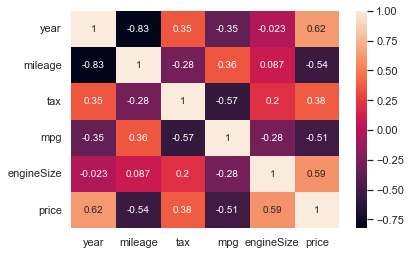

In [11]:
sns.heatmap(data[np.append(numerical, 'price')].corr(method='spearman'), annot=True)

There are correleations between modified target column and numerical columns, e.g. new cars cost more than older (by stats), cars with huge mileage has lower price than cars with lower mileage and etc. Lets make graphs to see what's going on

- Miles per galoon and price

Text(0.5, 1.0, 'Miles per galoon (mpg) vs price')

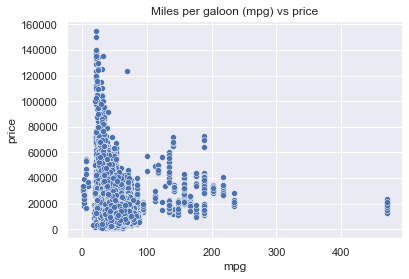

In [12]:
sns.scatterplot(
    x=data['mpg'],
    y=data['price']
).set_title('Miles per galoon (mpg) vs price')

Let see what cars are on the right side

In [13]:
mpg_outlier = data[data['mpg'] > 400]
mpg_outlier

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
8835,i3,2015,Automatic,29465,Electric,0,470.8,1.0,bmw,17400
6280,i3,2017,Automatic,3976,Hybrid,135,470.8,0.0,bmw,22999
3628,i3,2015,Automatic,65800,Hybrid,0,470.8,0.0,bmw,14285
6874,i3,2016,Automatic,68000,Hybrid,0,470.8,0.0,bmw,15990
4749,i3,2014,Automatic,42479,Hybrid,0,470.8,0.0,bmw,15450
2352,i3,2016,Automatic,8421,Hybrid,0,470.8,0.0,bmw,19490
3277,i3,2016,Automatic,43695,Hybrid,0,470.8,0.0,bmw,16482
10325,i3,2016,Automatic,41063,Other,0,470.8,0.6,bmw,17000
9924,i3,2016,Automatic,35446,Hybrid,0,470.8,0.0,bmw,16500
8375,i3,2017,Automatic,20321,Electric,135,470.8,0.0,bmw,18999


BMW i3 is hybrid model (fueltype - Electic / Petrol), and then it has 400 mpg.

- Year of production and price

Text(0.5, 1.0, 'Year od production (year) vs price')

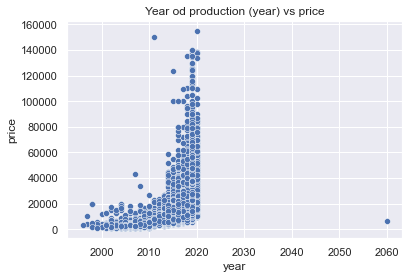

In [14]:
sns.scatterplot(
    x=data['year'],
    y=data['price']
).set_title('Year od production (year) vs price')

There is outlier (object has value 2060 in year column). It's only one.

In [15]:
data[data['year'] > 2020]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
17726,Fiesta,2060,Automatic,54807,Petrol,205,42.8,1.4,ford,6495


In [16]:
data = data[data['year'] <= 2020]

- Mileage and price

Text(0.5, 1.0, 'Mileage (mileage) and price')

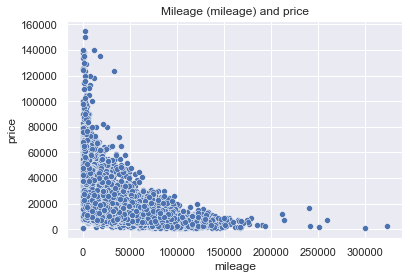

In [17]:
sns.scatterplot(
    x=data['mileage'],
    y=data['price']
).set_title('Mileage (mileage) and price')

- Tax and price

Text(0.5, 1.0, 'Tax (tax) and price')

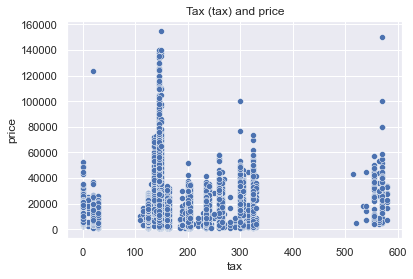

In [18]:
sns.scatterplot(
    x=data['tax'],
    y=data['price']
).set_title('Tax (tax) and price')

- Engine Size and price

Text(0.5, 1.0, 'Engine Size (engineSize) and price')

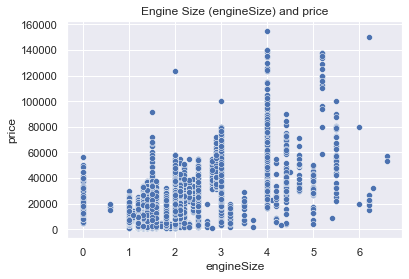

In [19]:
sns.scatterplot(
    x=data['engineSize'],
    y=data['price']
).set_title('Engine Size (engineSize) and price')

### Working with categorical columns
There are 3 categorical features: `model` (155 unique values), `transmission` (4 unique values), `fuelType` (5 unique values), `car_maker` (7 unique values)

Text(0.5, 1.0, 'Car makers (car_maker) and price')

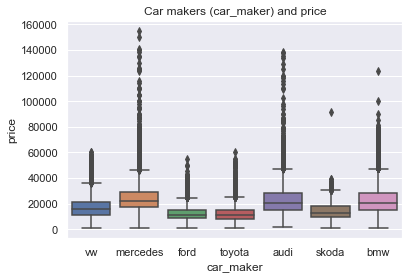

In [20]:
sns.boxplot(
    x=data['car_maker'],
    y=data['price']
).set_title('Car makers (car_maker) and price')

It seems that boxplots of mercedes, bmw, audi car makers are higher than others. Let's make a boolean feature with name `is_premium`

In [21]:
data['is_premium'] = data['car_maker'].apply(lambda x: 1 if x in ('bmw', 'mercedes', 'audi') else 0)

Text(0.5, 1.0, 'Price of premium / non-premium cars')

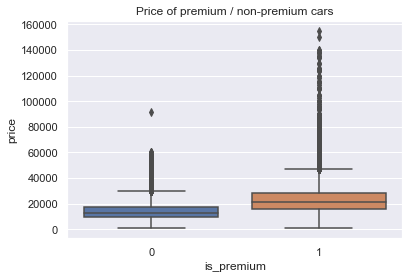

In [22]:
sns.boxplot(
    x=data['is_premium'], y=data['price']
).set_title('Price of premium / non-premium cars')

Text(0.5, 1.0, 'Type of Fuel and price')

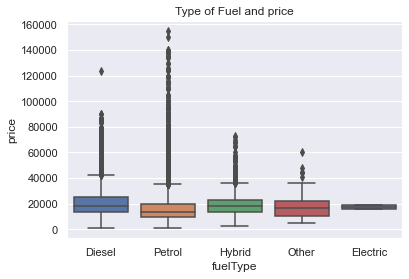

In [23]:
sns.boxplot(x=data['fuelType'], y=data['price']).set_title('Type of Fuel and price')

Text(0.5, 1.0, 'Type of transmission and price')

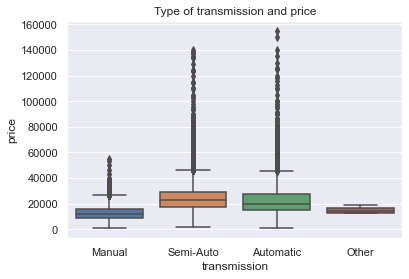

In [24]:
sns.boxplot(x=data['transmission'], y=data['price']).set_title('Type of transmission and price')

In [25]:
data['model'] = data['model'].apply(lambda x: x.strip())

In [26]:
data_premium = data[data['is_premium'] == 1].drop(columns=['is_premium'])
data_regular = data[data['is_premium'] == 0].drop(columns=['is_premium'])

X_prem, y_prem = data_premium.drop(columns=['price']), data_premium['price']
X_reg, y_reg= data_regular.drop(columns=['price']), data_regular['price']


### Making a pipeline for faster modelling

In [27]:
# data processing for categorical and numerical types

categorical_transform = Pipeline(
    [('ohe', OneHotEncoder(handle_unknown='ignore'))]
)

numerical_transform = Pipeline(
    [('scaler', MinMaxScaler())]
)

In [28]:
# combine transformers into one

preprocess_trans = ColumnTransformer(transformers=[
    ('numer', numerical_transform, numerical),
    ('caterog', categorical_transform, categor_cal),
])

In [29]:
# making two models (premium and regular cars)
# using traformed targer regressor in order to return original predictions
# by using converation log function and reverse exp

baseline_premium = Pipeline(
    steps=[('preprocess', preprocess_trans), ('model', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))]
)

baseline_reg = Pipeline(
    steps=[('preprocess', preprocess_trans), ('model', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))]
)

In [30]:
splitter = KFold(n_splits=5)
param_grid = {
    'model__regressor__alpha': np.linspace(0.0001, 10, 100)
}

In [31]:
gsv_prem = GridSearchCV(baseline_premium, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=splitter)
gsv_reg = GridSearchCV(baseline_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=splitter)

In [32]:
gsv_prem.fit(X_prem, y_prem)
gsv_reg.fit(X_reg, y_reg)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numer',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         array(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype=object)),
                                                                        ('caterog',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         array(['model', 'tr...
       7.67679091e+00, 7.77780000e+00, 7.87880909e+00, 7.97981818e+00,
       8.08082727e+00, 8.18183636e+00, 8.28284545e+00, 8.38385455e+00,
       8.48486364e+00, 8.58587273e+00, 8.68688182e+00, 8.78789091e+00,
       8.88890000e+00, 8.98990909e+00, 9.09091818e+00, 9.19192727e+00,
       9.29293636e+00, 9.39394545e+00, 9.49495455e+00, 9.59596364e+00,
       9.69697273e+00, 9.79798182e+00, 9.89899091e+00, 1.00000000e+01])},
             scoring='neg_mean_absolute_error')

In [33]:
gsv_prem.best_score_, gsv_reg.best_score_

(-2380.3828510354047, -1323.110879796556)

In [34]:
gsv_prem.best_params_, gsv_reg.best_params_

({'model__regressor__alpha': 0.10110909090909091},
 {'model__regressor__alpha': 0.5051454545454546})

In [35]:
baseline_premium.set_params(**gsv_prem.best_params_)
baseline_reg.set_params(**gsv_reg.best_params_)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  array(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype=object)),
                                                 ('caterog',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['model', 'transmission', 'fuelType', 'car_maker'], dtype=object))])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=0.5051454545454546)))])

In [36]:
from sklearn.model_selection import cross_validate

In [37]:
scr_pr = cross_validate(baseline_premium, X_prem, y_prem, cv=splitter, scoring='neg_mean_absolute_error', return_estimator=True, return_train_score=True)
scr_reg = cross_validate(baseline_reg, X_reg, y_reg, cv=splitter, scoring='neg_mean_absolute_error', return_estimator=True, return_train_score=True)

In [38]:
for i, step in enumerate(scr_pr):
    if step != 'estimator':
        print(step, scr_pr[step])

fit_time [0.04843593 0.04673219 0.04962587 0.04718399 0.048769  ]
score_time [0.00753093 0.00803375 0.00746822 0.00666595 0.007653  ]
test_score [-2402.90698236 -2356.47147086 -2372.01130612 -2340.0906309
 -2430.43386494]
train_score [-2364.48805204 -2376.259863   -2368.99401988 -2378.00372706
 -2353.65568932]


In [39]:
for i, step in enumerate(scr_reg):
    if step != 'estimator':
        print(step, scr_reg[step])

fit_time [0.06202793 0.05835605 0.05780077 0.05937719 0.05837393]
score_time [0.00845814 0.00933886 0.00919819 0.00829601 0.00821114]
test_score [-1336.98268666 -1333.53018399 -1295.8849818  -1343.08326517
 -1306.07328137]
train_score [-1317.6379444  -1316.64176007 -1326.12819617 -1310.68790825
 -1320.75047986]


In [40]:
model_prem = scr_pr['estimator'][3]
model_reg = scr_reg['estimator'][2]

In [41]:
import joblib

In [42]:
joblib.dump(model_prem, '../models_ml/prem_model.pkl')
joblib.dump(model_reg, '../models_ml/reg_model.pkl')

['../models_ml/reg_model.pkl']

In [43]:
model_a = joblib.load('../models_ml/prem_model.pkl')

In [79]:
type(model_a)

sklearn.pipeline.Pipeline

In [74]:
to_predict['is_premium'] = to_predict['car_maker'].apply(lambda x: 1 if x in ('bmw', 'mercedes', 'audi') else 0)

In [81]:
to_predict.columns

Index(['model', 'year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg',
       'engineSize', 'car_maker', 'id', 'is_premium'],
      dtype='object')

In [75]:
columns_test_predict = to_predict.drop(columns=['id', 'is_premium']).columns.values

In [754]:
def make_pred(model_1, model_2, series):
    if series['is_premium']:
        return model_1.predict(series[columns_test_predict].to_frame().T)[0]
    else:
        return model_2.predict(series[columns_test_predict].to_frame().T)[0]

In [755]:
result = pd.DataFrame(data=pd.concat([to_predict['id'], to_predict.apply(lambda x: make_pred(model_prem, model_reg, x), axis=1)], axis=1))

In [700]:
result.set_index('id', inplace=True)

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker
0,Q7,2019,Auto,3000.0,Petrol,20.0,87.0,4.0,Audi
